### This is a simple demo for extracting waveforms feature using SeisCLIP

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from model.model_seismic_clip import *

/Users/xusi/anaconda3/envs/pyg2.0/lib/python3.9/site-packages/torch/amp/autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


In [4]:
def load_model(model_name,model):
    param = torch.load(model_name,map_location=torch.device('cpu'))
    model.load_state_dict(param)
    return model

In [6]:
device = torch.device("cpu")
freeze_model = AUDIO_CLIP(
embed_dim = 384, text_input = 8,text_width = 512,text_layers=2,spec_model_size = 'small224',device_name = device).to(device)

model_name = './pretrained_models/pretrain_model_50_120.pt'

freeze_model = load_model(model_name,freeze_model)
# freeze_model.eval()

---------------AST Model Summary---------------
ImageNet pretraining: True, AudioSet pretraining: False
frequncey stride=10, time stride=10
number of patches=44


In [7]:
import numpy as np
import scipy.io as sio
from scipy.signal import stft
import matplotlib.pyplot as plt 

In [9]:
train_jump_array = sio.loadmat("./data/train_jump.mat")
stone_array = sio.loadmat("./data/stone.mat")


In [10]:
train_jump_data = train_jump_array['jump_703seconds'] 
stone_data = stone_array['stone_596_598seconds']
x = np.arange(0,800,0.002)
print(x.shape)
print(train_jump_data.shape)
print(stone_data.shape)

(400000,)
(400000, 2, 3)
(400000, 2, 3)


In [11]:
def cal_norm_spectrogram(x,window_length,nfft,sample_rate):
    spec = np.zeros([x.shape[0],3,int(x.shape[-1]/window_length * 2),int(nfft/2)])
    for n in range(x.shape[0]):
        for i in range(3):
            _, _, spectrogram = stft(x[n,i,:], fs=sample_rate, window='hann', nperseg=window_length, noverlap=int(window_length/2), nfft=nfft,boundary='zeros')
            spectrogram = spectrogram[1:,1:]
            # spectrogram = (spectrogram - spectrogram.mean())/spectrogram.std()+1e-3
            spec[n,i,:] = np.abs(spectrogram).transpose(1,0)
    return spec
def norm(x):
    data = x.copy()
    for i in range(x.shape[1]):
        for j in range(x.shape[2]):
            data[:,i,j] = (data[:,i,j] - data[:,i,j].mean())/data[:,i,j].std()
    return data

(40, 3, 125, 50)


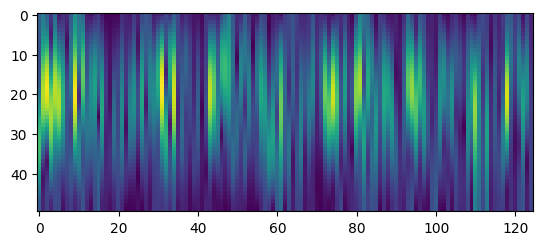

(40, 3, 125, 50)


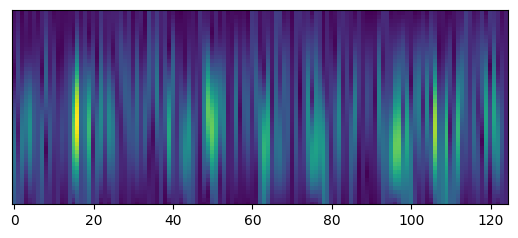

(40, 3, 125, 50)


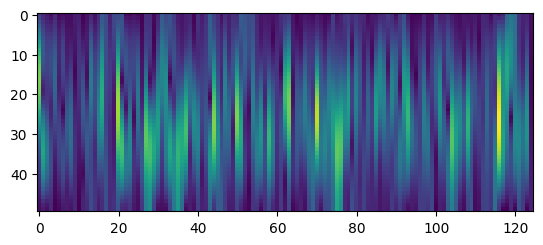

(40, 3, 125, 50)


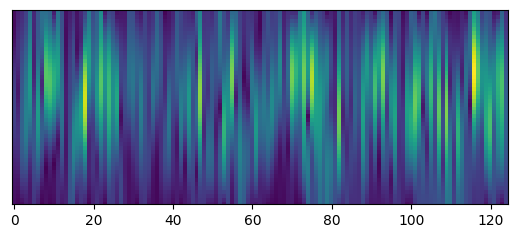

(20, 3, 125, 50)


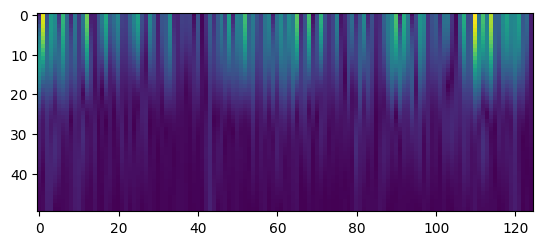

(20, 3, 125, 50)


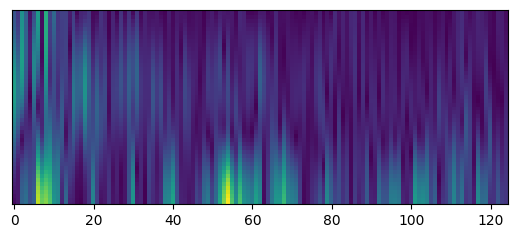

(500, 2, 3)
(2, 3, 500)
(2, 3, 125, 50)


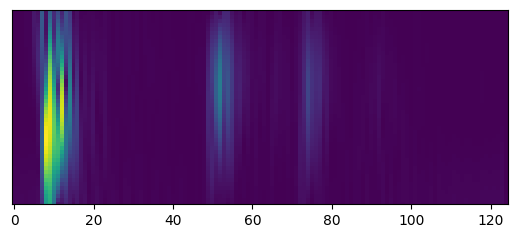

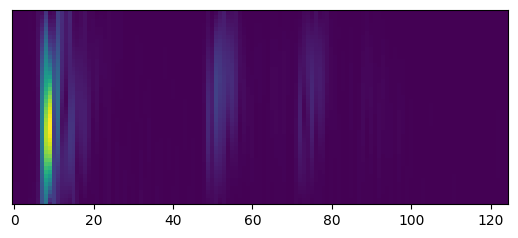

(500, 2, 3)
(2, 3, 500)
(2, 3, 125, 50)


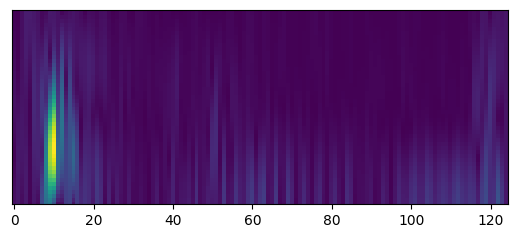

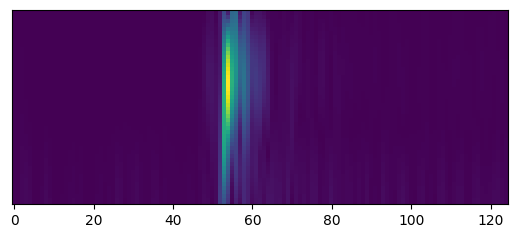

In [12]:
# subway_stone_data1 
t1 = 470
t2 = 490
dt = 500
subway_stone_data1 = np.zeros([500,2*(t2-t1),3])
for i in range(t1,t2,1):
    subway_stone_data1[:,2*(i-t1):2*(i-t1+1),:] = stone_data[i*dt:(i+1)*dt,:,:].copy()
subway_stone_data1 = norm(subway_stone_data1).transpose(1,2,0)
subway_stone_data1 = cal_norm_spectrogram(subway_stone_data1,8,100,500)
print(subway_stone_data1.shape)
plt.imshow(subway_stone_data1[20,0,:].T)
plt.show()
plt.ylim(0,49)
plt.yticks([])
# plt.savefig('./train_stone_data/stone_subway2.png',dpi=300,bbox_inches = 'tight')

# subway_stone_data2 
t1 = 110
t2 = 130
dt = 500
subway_stone_data2 = np.zeros([500,2*(t2-t1),3])
for i in range(t1,t2,1):
    subway_stone_data2[:,2*(i-t1):2*(i-t1+1),:] = stone_data[i*dt:(i+1)*dt,:,:].copy()
subway_stone_data2 = norm(subway_stone_data2).transpose(1,2,0)
subway_stone_data2 = cal_norm_spectrogram(subway_stone_data2,8,100,500)
print(subway_stone_data2.shape)
plt.imshow(subway_stone_data2[20,0,:].T)
plt.show()


# subway_jump_data1 
t1 = 180
t2 = 200
dt = 500
subway_jump_data1 = np.zeros([500,2*(t2-t1),3])
for i in range(t1,t2,1):
    subway_jump_data1[:,2*(i-t1):2*(i-t1+1),:] = train_jump_data[i*dt:(i+1)*dt,:,:].copy()
subway_jump_data1 = norm(subway_jump_data1).transpose(1,2,0)
subway_jump_data1 = cal_norm_spectrogram(subway_jump_data1,8,100,500)
print(subway_jump_data1.shape)
plt.imshow(subway_jump_data1[20,0,:].T)
plt.show()

# subway_jump_data2
t1 = 555
t2 = 575
dt = 500
subway_jump_data2 = np.zeros([500,2*(t2-t1),3])
for i in range(t1,t2,1):
    subway_jump_data2[:,2*(i-t1):2*(i-t1+1),:] = train_jump_data[i*dt:(i+1)*dt,:,:].copy()
subway_jump_data2 = norm(subway_jump_data2).transpose(1,2,0)
subway_jump_data2 = cal_norm_spectrogram(subway_jump_data2,8,100,500)
print(subway_jump_data2.shape)
plt.imshow(subway_jump_data2[20,0,:].T)
plt.ylim(0,49)
plt.yticks([])
# plt.savefig('./train_stone_data/subway_spec.png',dpi=300,bbox_inches = 'tight')
plt.show()


# blank_jump_data2
t1 = 10
t2 = 20
dt = 500
blank_jump_data = np.zeros([500,2*(t2-t1),3])
for i in range(t1,t2,1):
    blank_jump_data[:,2*(i-t1):2*(i-t1+1),:] = train_jump_data[i*dt:(i+1)*dt,:,:].copy()
blank_jump_data = norm(blank_jump_data).transpose(1,2,0)
blank_jump_data = cal_norm_spectrogram(blank_jump_data,8,100,500)
print(blank_jump_data.shape)
plt.imshow(blank_jump_data[10,0,:].T)
plt.show()

# blank_stone_data
t1 = 10
t2 = 20
dt = 500
blank_stone_data = np.zeros([500,2*(t2-t1),3])
for i in range(t1,t2,1):
    blank_stone_data[:,2*(i-t1):2*(i-t1+1),:] = stone_data[i*dt:(i+1)*dt,:,:].copy()
blank_stone_data = norm(blank_stone_data).transpose(1,2,0)
blank_stone_data = cal_norm_spectrogram(blank_stone_data,8,100,500)
print(blank_stone_data.shape)
plt.imshow(blank_stone_data[10,0,:].T)
plt.ylim(0,49)
plt.yticks([])
# plt.savefig('./train_stone_data/noise_spec.png',dpi=300,bbox_inches = 'tight')
plt.show()




# train_data 
dt = 500
t1 = int(596.75*dt)
t2 = int(597.75*dt)
stone_fall_data = stone_data[t1:t2,:,:].copy()
print(stone_fall_data.shape)
stone_fall_data = norm(stone_fall_data).transpose(1,2,0)
print(stone_fall_data.shape)
stone_fall_data = cal_norm_spectrogram(stone_fall_data,8,100,500)
print(stone_fall_data.shape)
plt.imshow(stone_fall_data[0,0,:].T)
plt.ylim(0,49)
plt.yticks([])
# plt.savefig('./train_stone_data/stone_spec1.png',dpi=300,bbox_inches = 'tight')
plt.show()
plt.imshow(stone_fall_data[1,0,:].T)
plt.ylim(0,49)
plt.yticks([])
# plt.savefig('./train_stone_data/stone_spec2.png',dpi=300,bbox_inches = 'tight')
plt.show()


# train_data 
t1 = 703
t2 = 704
dt = 500
jump_data = train_jump_data[t1*dt:t2*dt,:,:].copy()
print(jump_data.shape)
jump_data = norm(jump_data).transpose(1,2,0)
print(jump_data.shape)
jump_data = cal_norm_spectrogram(jump_data,8,100,500)
print(jump_data.shape)
plt.imshow(jump_data[0,0,:].T)
plt.ylim(0,49)
plt.yticks([])
# plt.savefig('./train_stone_data/jump_spec1.png',dpi=300,bbox_inches = 'tight')
plt.show()

plt.imshow(jump_data[1,0,:].T)
plt.ylim(0,49)
plt.yticks([])
# plt.savefig('./train_stone_data/jump_spec2.png',dpi=300,bbox_inches = 'tight')
plt.show()



In [13]:
freeze_model.eval()
concat_data = np.concatenate([jump_data,stone_fall_data,subway_stone_data1,subway_stone_data2,subway_jump_data1,subway_jump_data2,blank_stone_data,blank_jump_data],axis = 0)
# concat_data = np.concatenate([jump_data,stone_fall_data],axis = 0)

concat_data_torch = torch.tensor(concat_data[:,:,0:120,:]).to(device)
print(concat_data_torch.shape)
temp_output = freeze_model.encode_audio(concat_data_torch)

torch.Size([204, 3, 120, 50])


In [15]:
from sklearn.decomposition import PCA

(204, 2)


/var/folders/0j/ghv94v0d5rjg_y_rsjwtjkpc0000gn/T/ipykernel_61095/2797411652.py:32: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


([], [])

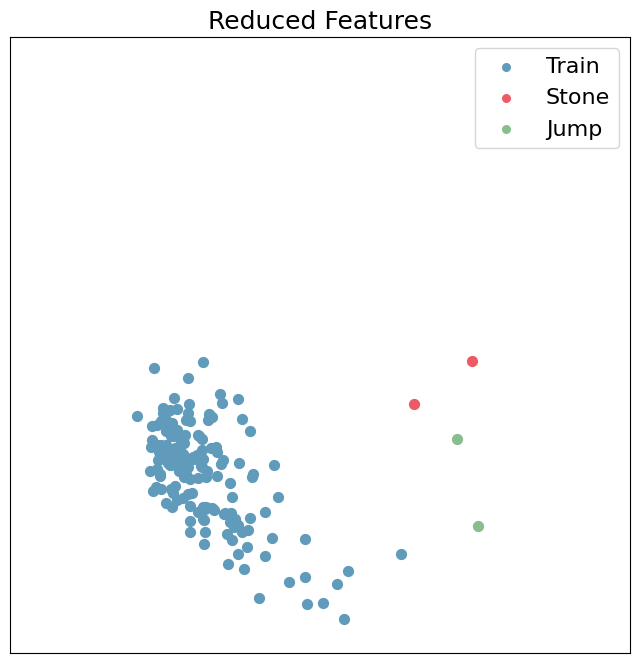

In [20]:
# label = np.zeros(204+len(earth_output),dtype='int')
label = np.zeros(164,dtype='int')

label[0:2] = 1
label[2:4] = 2
label[164:204] = 3

pca = PCA(n_components=2)
reduced_features = pca.fit_transform(temp_output.detach().cpu().numpy())  # (batch_size, 2)
print(reduced_features.shape)


labels = label.copy()
# 创建颜色映射
unique_labels = np.unique(labels)
colors = ['#609bbb', '#ed5a65', '#89bd8d', '#e6a382', '#ad6598', '#609bbb']  # 可以根据需要自定义颜色
# colors = ['#1781b5', '#1781b5', '#ed5a65', '#ed5a65', '#ed5a65', '#ed5a65']  # 可以根据需要自定义颜色

label_list = ['Train','Stone','Jump','Noise','Earthquake','Exotic events']
label_color_map = {label: color for label, color in zip(unique_labels, colors)}

plt.figure(figsize = (8,8), dpi = 100)
# 绘制散点图
for label in unique_labels:
    indices = np.where(labels == label)
    if label<5:
        plt.scatter(reduced_features[indices, 0], reduced_features[indices, 1], c=label_color_map[label],label=label_list[label],s = 50)
    else:
        plt.scatter(reduced_features[indices, 0], reduced_features[indices, 1], c=label_color_map[label],s = 50)
        
legend = plt.legend(loc = 0,prop={'size': 16})
for handle in legend.legendHandles:
    handle.set_sizes([30])  # 设置标志的大小
    
# plt.xlim(-20,20)
# plt.ylim(-20,20)


plt.xlim(-15,30)
plt.ylim(-10,20)
plt.title('Reduced Features',fontsize = 18)

plt.xticks([])
plt.yticks([])
# plt.savefig('./train_stone_data/finetune_3_feature.png',dpi=300,bbox_inches = 'tight')

# plt.show()
# plt.close()